In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM,Dropout
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

import warnings
warnings.filterwarnings("ignore")

import os 
os.environ["TF_CPP_MIN_LOG_LEVEL"]="3"
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [2]:
data=pd.read_csv("/content/drive/MyDrive/TSLA.csv")

In [3]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300
1,2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100
2,2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800
3,2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800
4,2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900


In [4]:
def check_df(dataframe,head=5):
    print("#################### Shape #################### ")
    print(dataframe.shape)
    print("#################### Types #################### ")
    print(dataframe.dtypes)
    print("#################### Head #################### ")
    print(dataframe.head(head))
    print("#################### Tail #################### ")
    print(dataframe.dtypes)
    print("#################### NA #################### ")
    print(dataframe.isnull().sum())
    print("#################### Quantiles #################### ")
    print(dataframe.quantile([0,0.5,0.50,0.95,0.99,1]).T)
check_df(data)

#################### Shape #################### 
(2416, 7)
#################### Types #################### 
Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object
#################### Head #################### 
         Date       Open   High        Low      Close  Adj Close    Volume
0  2010-06-29  19.000000  25.00  17.540001  23.889999  23.889999  18766300
1  2010-06-30  25.790001  30.42  23.299999  23.830000  23.830000  17187100
2  2010-07-01  25.000000  25.92  20.270000  21.959999  21.959999   8218800
3  2010-07-02  23.000000  23.10  18.709999  19.200001  19.200001   5139800
4  2010-07-06  20.000000  20.00  15.830000  16.110001  16.110001   6866900
#################### Tail #################### 
Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object
#################### NA 

In [5]:
data["Date"]=pd.to_datetime(data["Date"])

In [6]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300
1,2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100
2,2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800
3,2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800
4,2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900


In [7]:
tesla_data=data[["Date","Close"]]
tesla_data.head()

,Date,Close
0,2010-06-29,23.889999
1,2010-06-30,23.830000
2,2010-07-01,21.959999
3,2010-07-02,19.200001
4,2010-07-06,16.110001


In [8]:
print("Min. Tarih:",tesla_data["Date"].min())
print("Max. Tarih:",tesla_data["Date"].max())

Min. Tarih: 2010-06-29 00:00:00
Max. Tarih: 2020-02-03 00:00:00


In [9]:
tesla_data.index=tesla_data["Date"]
tesla_data

,Date,Close
Date,,
2010-06-29,2010-06-29,23.889999
2010-06-30,2010-06-30,23.830000
2010-07-01,2010-07-01,21.959999
2010-07-02,2010-07-02,19.200001
2010-07-06,2010-07-06,16.110001
...,...,...
2020-01-28,2020-01-28,566.900024
2020-01-29,2020-01-29,580.989990
2020-01-30,2020-01-30,640.809998


In [10]:
tesla_data.drop("Date",axis=1,inplace=True)
tesla_data

,Close
Date,
2010-06-29,23.889999
2010-06-30,23.830000
2010-07-01,21.959999
2010-07-02,19.200001
2010-07-06,16.110001
...,...
2020-01-28,566.900024
2020-01-29,580.989990
2020-01-30,640.809998


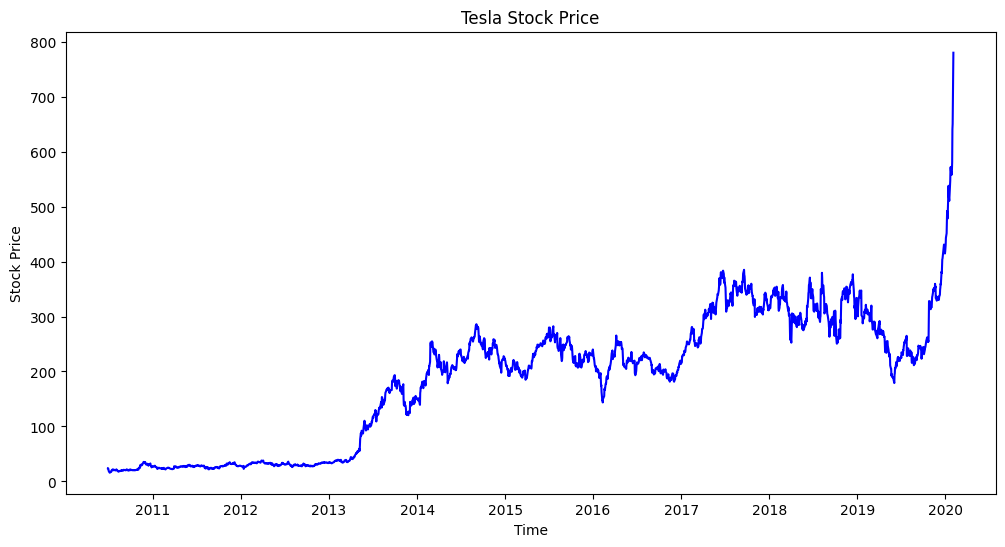

In [11]:
result_data=tesla_data.copy()
plt.figure(figsize=(12,6))
plt.plot(tesla_data["Close"],color="blue");
plt.ylabel("Stock Price")
plt.title("Tesla Stock Price")
plt.xlabel("Time")
plt.show()

In [12]:
tesla_data=tesla_data.values
tesla_data[0:5]

array([[23.889999],
       [23.83    ],
       [21.959999],
       [19.200001],
       [16.110001]])

In [13]:
tesla_data=tesla_data.astype("float32")

In [14]:
tesla_data

array([[ 23.89],
       [ 23.83],
       [ 21.96],
       ...,
       [640.81],
       [650.57],
       [780.  ]], dtype=float32)

In [15]:
def split_data(dataframe,test_size):
    pos=int(round(len(dataframe)*(1-test_size)))
    train=dataframe[:pos]
    test=dataframe[pos:]
    return train,test,pos
train,test,pos=split_data(tesla_data,0.20)
print(train.shape,test.shape)

(1933, 1) (483, 1)


In [16]:
scaler_train=MinMaxScaler(feature_range=(0,1))
train=scaler_train.fit_transform(train)
scaler_test=MinMaxScaler(feature_range=(0,1))
test=scaler_test.fit_transform(test)
train[0:5]

array([[0.02191224],
       [0.02174973],
       [0.01668472],
       [0.0092091 ],
       [0.00083966]], dtype=float32)

In [17]:
test[0:5]

array([[0.25685903],
       [0.24829045],
       [0.25511202],
       [0.24978784],
       [0.2465767 ]], dtype=float32)

In [18]:
def create_features(data,lookback):
    X,Y=[],[]
    for i in range(lookback,len(data)):
        X.append(data[i-lookback:i,0])
        Y.append(data[i,0])
    return np.array(X),np.array(Y)

lookback=20

X_train,y_train=create_features(train,lookback)
X_test,y_test=create_features(test,lookback)
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(1913, 20) (1913,) (463, 20) (463,)


In [ ]:
X_train[0:5]


In [20]:
y_test[0:5]


array([0.14734703, 0.1796416 , 0.21088794, 0.20020628, 0.18416718],
      dtype=float32)

In [21]:
X_train=np.reshape(X_train,(X_train.shape[0],1,X_train.shape[1]))
X_test=np.reshape(X_test,(X_test.shape[0],1,X_test.shape[1]))
y_train=y_train.reshape(-1,1)
y_test=y_test.reshape(-1,1)
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(1913, 1, 20) (1913, 1) (463, 1, 20) (463, 1)


In [22]:
model=Sequential()
model.add(LSTM(units=50,
              activation="relu",
              input_shape=(X_train.shape[1],lookback)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                14200     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 14,251
Trainable params: 14,251
Non-trainable params: 0
_________________________________________________________________


In [23]:
model.compile(loss="mean_squared_error",optimizer="adam")
callbacks=[EarlyStopping(monitor="val_loss",patience=3,verbose=1,mode="min"),
          ModelCheckpoint(filepath="mymodel.h5",monitor="val_loss",mode="min",
                         save_best_only=True,save_weights_only=False,verbose=1)]
history = model.fit(x=X_train,
                    y=y_train,
                    epochs=100,
                    batch_size=20,
                    validation_data=(X_test,y_test),
                    callbacks=callbacks,
                    shuffle=False)

Epoch 1/100
83/96 [========================>.....] - ETA: 0s - loss: 0.0072
Epoch 1: val_loss improved from inf to 0.00419, saving model to mymodel.h5
96/96 [==============================] - 2s 7ms/step - loss: 0.0084 - val_loss: 0.0042
Epoch 2/100
90/96 [===========================>..] - ETA: 0s - loss: 0.0060
Epoch 2: val_loss improved from 0.00419 to 0.00365, saving model to mymodel.h5
96/96 [==============================] - 0s 3ms/step - loss: 0.0065 - val_loss: 0.0037
Epoch 3/100
84/96 [=========================>....] - ETA: 0s - loss: 0.0041
Epoch 3: val_loss did not improve from 0.00365
96/96 [==============================] - 0s 3ms/step - loss: 0.0056 - val_loss: 0.0039
Epoch 4/100
82/96 [========================>.....] - ETA: 0s - loss: 0.0036
Epoch 4: val_loss improved from 0.00365 to 0.00351, saving model to mymodel.h5
96/96 [==============================] - 0s 4ms/step - loss: 0.0048 - val_loss: 0.0035
Epoch 5/100
89/96 [==========================>...] - ETA: 0s - loss:

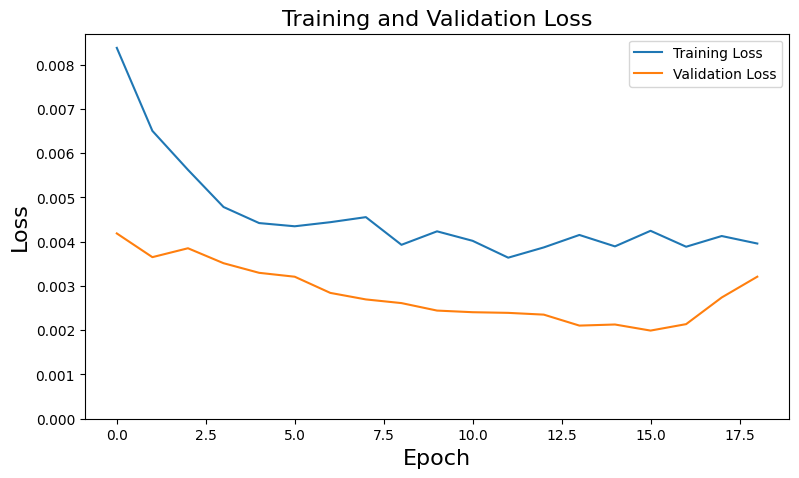

In [24]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,2)
plt.plot(history.history["loss"],label="Training Loss")
plt.plot(history.history["val_loss"],label="Validation Loss")
plt.legend(loc="upper right")
plt.xlabel("Epoch",fontsize=16)
plt.ylabel("Loss",fontsize=16)
plt.ylim([0,max(plt.ylim())])
plt.title("Training and Validation Loss",fontsize=16)
plt.show()

In [25]:
loss=model.evaluate(X_test,y_test,batch_size=20)

24/24 [==============================] - 0s 3ms/step - loss: 0.0032


In [26]:
print("\nTest loss:%.1f%%"%(100.0*loss))


Test loss:0.3%


In [27]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict=scaler_train.inverse_transform(train_predict)
test_predict=scaler_test.inverse_transform(test_predict)
y_train=scaler_train.inverse_transform(y_train)
y_test=scaler_test.inverse_transform(y_test)

15/15 [==============================] - 0s 2ms/step


In [29]:
train_rmse=np.sqrt(mean_squared_error(y_train,train_predict))
test_rmse=np.sqrt(mean_squared_error(y_test,test_predict,))
print(f"Train RMSE:{train_rmse}")
print(f"Test RMSE:{test_rmse}")

Train RMSE:15.704487800598145
Test RMSE:34.052791595458984


In [30]:
train_prediction_data=result_data[lookback:pos]
train_prediction_data["Predicted"]=train_predict
train_prediction_data.head()

,Close,Predicted
Date,,
2010-07-28,20.719999,37.752796
2010-07-29,20.350000,37.752796
2010-07-30,19.940001,37.752796
2010-08-02,20.920000,37.752796
2010-08-03,21.950001,37.752796


In [31]:
test_prediction_data=result_data[pos+lookback:]
test_prediction_data["Predicted"]=test_predict
test_prediction_data.head()

,Close,Predicted
Date,,
2018-04-03,267.529999,325.602814
2018-04-04,286.940002,321.519592
2018-04-05,305.720001,320.814911
2018-04-06,299.299988,322.271057
2018-04-09,289.660004,322.187286


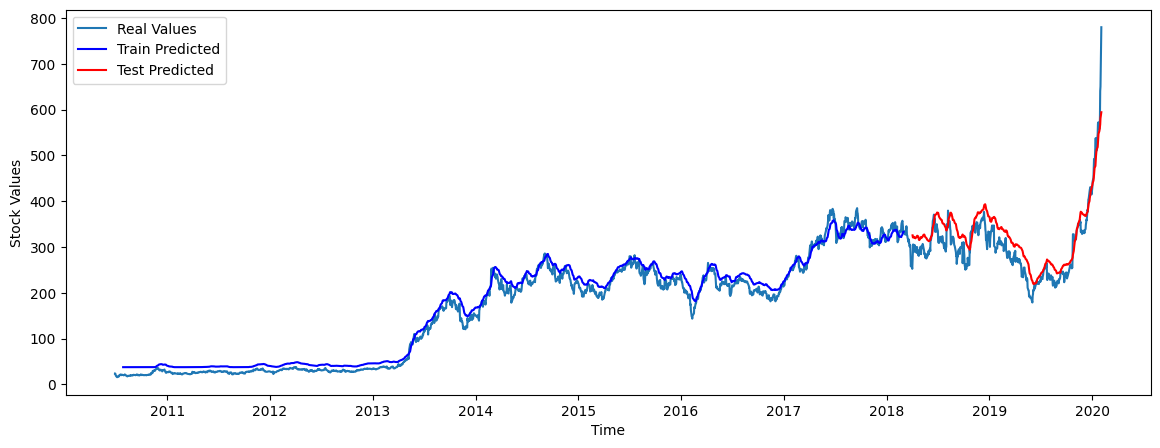

In [32]:
plt.figure(figsize=(14,5))
plt.plot(result_data,label="Real Values")
plt.plot(train_prediction_data["Predicted"],color="blue",label="Train Predicted")
plt.plot(test_prediction_data["Predicted"],color="red",label="Test Predicted")
plt.xlabel("Time")
plt.ylabel("Stock Values")
plt.legend()
plt.show()